In [2]:
## initialization 1214

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import constrNMPy
import os 
import warnings

from matplotlib import gridspec
from scipy import sparse, special, stats

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)

# color pallette
[gr,ye,re,bl,pu,ir,ak] = ['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2','#BEB8DC', '#E7DAD2','#999999']
[vio, grb, lig, sil, aqua] = ['#8c84cf','#6699CC','#66CC99','#C0C0C0','#6db3bc']
# set the style of the plots
az.style.use("arviz-white")

# 1 Data Preprocessing
Loading, Screening and Contrast Shifting

In [3]:
import dill

# load data
with open('./all_data.pkl', 'rb') as f:
    all_data = dill.load(f)  # obj = dill.load(file)
    
maxsubj = 32; maxblock = 20; maxtrial = 50

# Screening data by 3 SD from the mean RT
for iS in range(1, maxsubj + 1):
    subject_data = all_data[iS]  # all blocks for this subject
    temp_RT = []
    temp_count = 0
    ## calculate RT mean and SD for each subject
    for iB in range(1, maxblock + 1):
        key = f"{iB}_block"
        block_data = subject_data[iB - 1]  # read current block
        temp_RT.append(block_data['RT'])
    temp_RT = np.concatenate(temp_RT)
    ## Screening data by 3 SD from the mean
    for iB in range(1, maxblock + 1):
        key = f"{iB}_block"
        block_data = subject_data[iB - 1]
        all_data[iS][iB - 1]['Qualified'] = np.logical_and(block_data['RT'] > np.mean(temp_RT) - 3 * np.std(temp_RT),
                                                           block_data['RT'] < np.mean(temp_RT) + 3 * np.std(temp_RT))
        temp_count += np.sum(all_data[iS][iB - 1]['Qualified'])
    print(1000 - temp_count, end=' ') 
    
# Shifting the ContrastSeq to one-ahead
for iS in range(1, maxsubj + 1):
    subject_data = all_data[iS]  # all blocks for this subject
    for iB in range(1, maxblock + 1):
        key = f"{iB}_block"
        block_data = subject_data[iB - 1]  # read current block
        block_data['ContrastSeq'] = block_data['ContrastSeq'].shift(1)


16 10 3 16 16 17 11 19 14 12 15 15 18 6 18 13 23 16 8 12 22 16 18 22 14 12 18 16 20 23 9 12 

# 2 Basic Model Simulation

## 2.1 Bayesian Perceptual Model

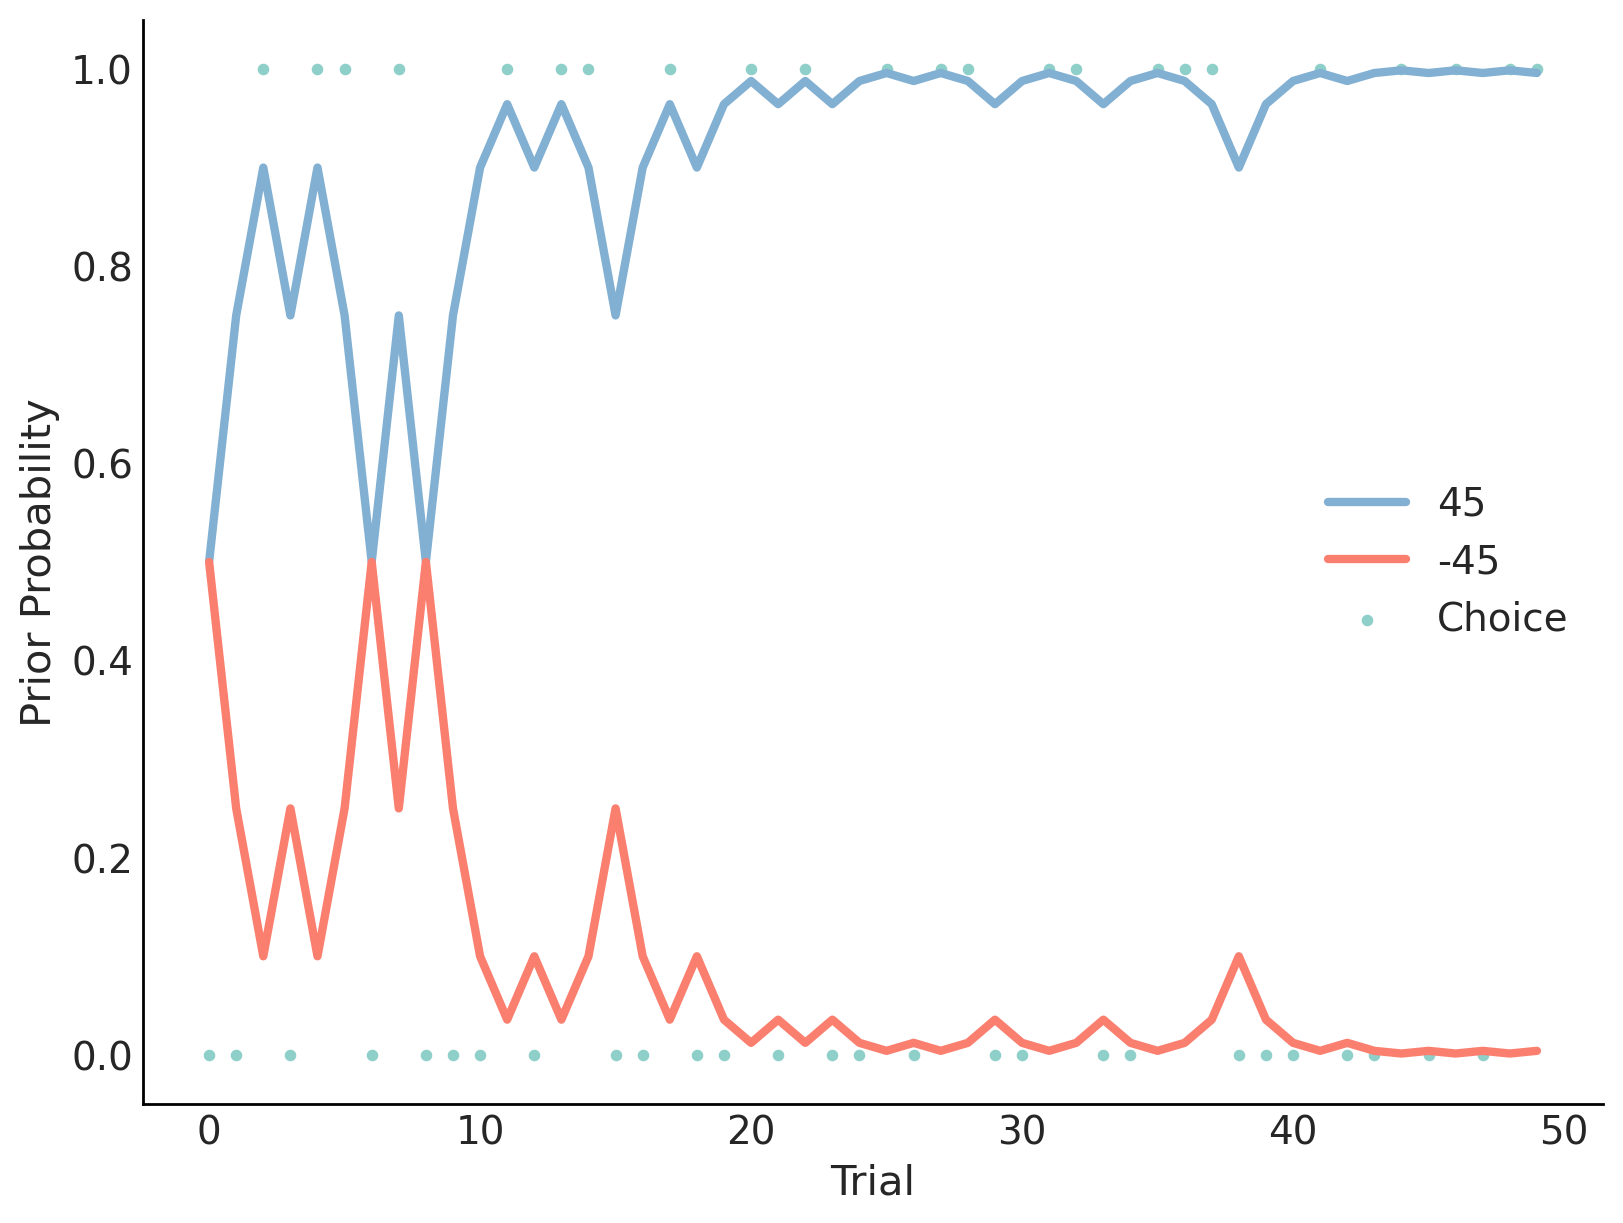

In [4]:
import numpy as np

def bayesian_update(prior, likelihood_correct, stim_ori, observed_correct, weight):
    """
    Update the prior belief to posterior belief.
    :param prior: [p, 1-p] for 45 and -45
    :param likelihood_correct: usually 0.75
    :param stim_ori: 0 or 1 for 45 and -45
    :param observed_correct: 1 or 0
    :param weight: the weight of the update
    
    :return: updated posterior
    """
    # Likelihood
    if stim_ori == 0:
        likelihood = np.array([likelihood_correct, 1 - likelihood_correct])
    else:
        likelihood = np.array([1 - likelihood_correct, likelihood_correct])
    
    # Update the prior
    if observed_correct:
        posterior = prior * likelihood * weight
    else:
        posterior = prior * (1 - likelihood) * weight
    
    # Normalize the posterior
    posterior = posterior / np.sum(posterior)
    return posterior

# Initial Prior
prior = np.array([0.5, 0.5])  # 0.5 for each orientation 45 and -45

# Likelihood, we assume the task diffuculty is always at threshold level
likelihood_correct = 0.75

# Simulate the experiment
num_trials = 50
weight = 0.1

all_priors = []
all_choice_ori = []

for trial in range(num_trials):
    # store the prior
    all_priors.append(prior)
    # the current orientation is randomly chosen
    actual_orientation = np.random.choice([0, 1])
    
    # the subject's response is determined by the likelihood
    observed_correct = np.random.rand() < likelihood_correct
    if observed_correct:
        choice_orientation = actual_orientation
    else:
        choice_orientation = 1 - actual_orientation
    
    # store the choice orientation
    all_choice_ori.append(choice_orientation)

    # update the prior
    posterior = bayesian_update(prior, likelihood_correct, actual_orientation, observed_correct, weight)
    prior = posterior
    
    # print the posterior
    # print(f"Trial {trial + 1}: Actual orientation: {actual_orientation}, Accuracy: {observed_correct}, Posterior: {posterior}")
    
# plot the priors
all_priors = np.array(all_priors)
plt.figure(figsize=(8, 6))
plt.plot(all_priors[:, 0], label="45", color=bl, linewidth=3)
plt.plot(all_priors[:, 1], label="-45", color= re, linewidth=3)
plt.scatter(np.arange(num_trials), all_choice_ori, color=gr, s=10, label="Choice")
plt.xlabel("Trial")
plt.ylabel("Prior Probability")
plt.legend()
plt.show()
    

Above is solely a bayesian updating demo.

However, in real world, the choice is made based on the posterior and update happens after that.

And the prior shouln't be so truculent.

In [4]:
def bayesian_percept_per_trial(prior, likelihood_correct, stim_ori, update_weight):
    """
    Update the prior belief to posterior belief.
    :param prior: [p, 1-p] for 45 and -45
    :param likelihood_correct: usually 0.75
    :param stim_ori: 0 or 1 for 45 and -45
    :param update_weight: the weight of the update
    
    :return: posterior, percept_ori, accuracy and updated prior
    """
    # Likelihood
    if stim_ori == 0:
        likelihood = np.array([likelihood_correct, 1 - likelihood_correct])
    else:
        likelihood = np.array([1 - likelihood_correct, likelihood_correct])
    
    # Calculate the posterior
    posterior = prior * likelihood 
    
    # Normalize the posterior
    posterior = posterior / np.sum(posterior)
    
    # Make a decision
    percept_ori = np.random.choice([0, 1], p=posterior)
    accuracy = (percept_ori == stim_ori)
    
    # Update the prior
    updated_prior = prior * likelihood * update_weight + prior * (1 - update_weight)
    updated_prior = updated_prior / np.sum(updated_prior)
    
    return posterior, percept_ori, accuracy, updated_prior

def attention_fluctuation(base_accuracy=0.75, fluctuation_range=0.1):
    """
    Simulating some trials with attentional flunctuation
    
    :param trial
    :param base_accuracy
    :param fluctuation_range
    
    :return: likelihood_correct after flunctuation
    """
    fluctuation = np.random.uniform(-fluctuation_range, fluctuation_range)
    return max(0, min(1, base_accuracy + fluctuation))


### Intializing a Demo
init_prior = np.array([0.5,0.5])
base_accuracy = 0.75
updated_weight = 0.1
lapse_rate = 0.05
trial_num = 50
    
# test
# Create a DataFrame to store the data
trial_data = pd.DataFrame(columns=['Trial', 'Stimulus', 'Likelihood', 'Percept', 'Accuracy', 'Prior 0', 'Prior 1'])

for itest in range(trial_num):
    if itest == 0:
        prior = init_prior
    else:
        prior = updated_prior
    stim_ori = np.random.choice([0,1])
    likelihood_correct = attention_fluctuation() 
    
    # Guessing if lapsed
    if np.random.rand() < lapse_rate:
        likelihood_correct = 0.5 
    _, percept_ori, accuracy, updated_prior = bayesian_percept_per_trial(prior, likelihood_correct, stim_ori, updated_weight)
    
    # Store the data
    temp_df = pd.DataFrame([[itest + 1, stim_ori, likelihood_correct, percept_ori, accuracy, prior[0], prior[1]]],
                            columns=['Trial', 'Stimulus', 'Likelihood', 'Percept', 'Accuracy', 'Prior 0', 'Prior 1'])
    trial_data = trial_data.append(temp_df, ignore_index=True)

trial_data.head()


,Trial,Stimulus,Likelihood,Percept,Accuracy,Prior 0,Prior 1
0,1,1,0.840431,1,True,0.500000,0.500000
1,2,0,0.681323,0,True,0.482083,0.517917
2,3,1,0.657225,1,True,0.491620,0.508380
3,4,1,0.672097,1,True,0.483350,0.516650
4,5,0,0.742753,0,True,0.474308,0.525692


## 2.2 Reinforcement Learning Decision Model

### 2.2.1 Model Free RL

In [78]:
import numpy as np

# Params Setting
learning_rate = 0.1
discount_factor = 0 # random choice, thus no planning?
num_trials = 100
epsilon = 0.1  # exploration rate

# Q Table Initialization
# 4 state, ori (0:45, 1:n45) x key (0: /  \,  1:\  /)
Q = np.zeros((4, 2))  # 4 states x 2 actions (Choose L or R)

# Demonstration of the world
# State 0: 45  / \ - Correct action: 0
# State 1: 45  \ / - Correct action: 1
# State 2: -45 / \ - Correct action: 1
# State 3: -45 \ / - Correct action: 0


def softmax(x):
    """
    Compute softmax values for each sets of scores in x.
    """
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def RL_Q_run_trial(Q, epsilon, learning_rate, discount_factor, current_state):
    """
    Run a single trial of Q-learning and update the Q-table.
    
    params Q: Q-table
    params epsilon: exploration rate
    params learning_rate: learning rate
    params discount_factor: discount factor
    
    Returns:
    updated Q, correct_action this trial, actual action, reward, td_error
    
    """
    # What is the current state?
    if current_state == None:
        current_state = np.random.choice([0, 1, 2, 3]) # randomly choose a state when not given

    # Exploration vs. Exploitation
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.choice([0, 1])  # Exploration: randomly choose a action
    else:
        # Exploitation: choose the best action
        # Using softmax to choose the best action
        action = np.random.choice([0, 1], p=softmax(Q[current_state]))

    # Reward: 1 if correct, 0 if incorrect
    # Correct action is the same as the current state
    correct_action = 0 if current_state in [0, 3] else 1
    reward = 1 if action == correct_action else 0

    # Q Learning Update
    # Since each trial is independent by itself, so we calculate the weighted sum of all possible states
    temp_td_all = []
    for next_state in range(4):
        next_best_action = np.argmax(Q[next_state])
        td_target = reward + discount_factor * Q[next_state][next_best_action]
        td_error = td_target - Q[current_state][action]
        temp_td_all.append(td_error)
    td_error = np.mean(temp_td_all)
    
    # Update the Q table
    Q[current_state][action] += learning_rate * td_error
    
    return Q, current_state, correct_action, action, reward, td_error   


Trial 1: State: 1, Correct Action: 1, Action: 1, Reward: 1, TD Error: 1.0
Trial 2: State: 0, Correct Action: 0, Action: 0, Reward: 1, TD Error: 1.0225
Trial 3: State: 2, Correct Action: 1, Action: 1, Reward: 1, TD Error: 1.04550625
Trial 4: State: 3, Correct Action: 0, Action: 1, Reward: -1, TD Error: -0.930969859375
Trial 5: State: 0, Correct Action: 0, Action: 0, Reward: 1, TD Error: 0.9667801406250001
Trial 6: State: 1, Correct Action: 1, Action: 1, Reward: 1, TD Error: 0.9907826937890625
Trial 7: State: 2, Correct Action: 1, Action: 1, Reward: 1, TD Error: 1.0085246793993163
Trial 8: State: 2, Correct Action: 1, Action: 1, Reward: 1, TD Error: 0.9303640167458693
Trial 9: State: 0, Correct Action: 0, Action: 0, Reward: 1, TD Error: 0.957772286000083
Trial 10: State: 1, Correct Action: 1, Action: 1, Reward: 1, TD Error: 0.9791719071186786
Trial 11: State: 0, Correct Action: 0, Action: 0, Reward: 1, TD Error: 0.905576301745247
Trial 12: State: 1, Correct Action: 1, Action: 1, Reward: 

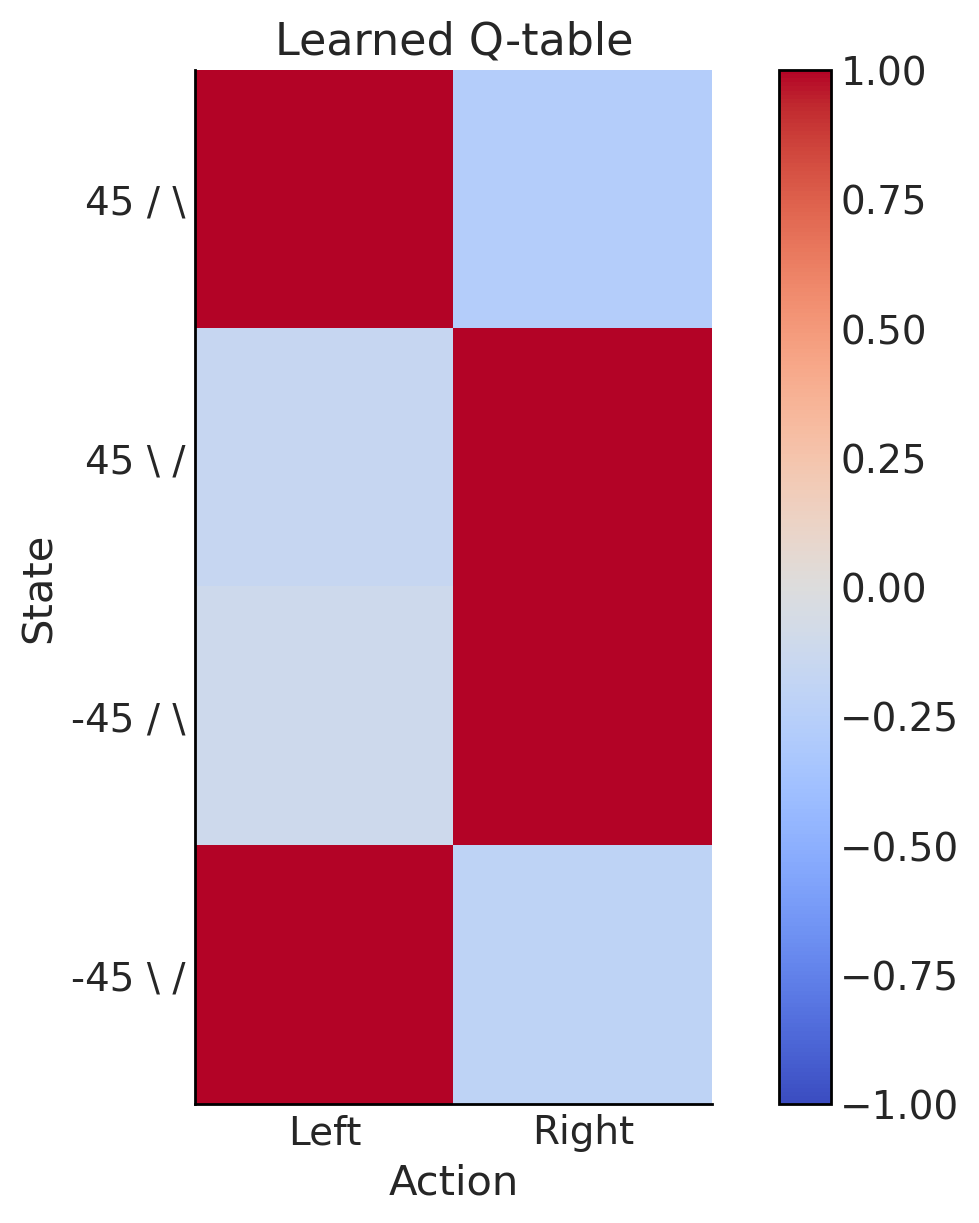

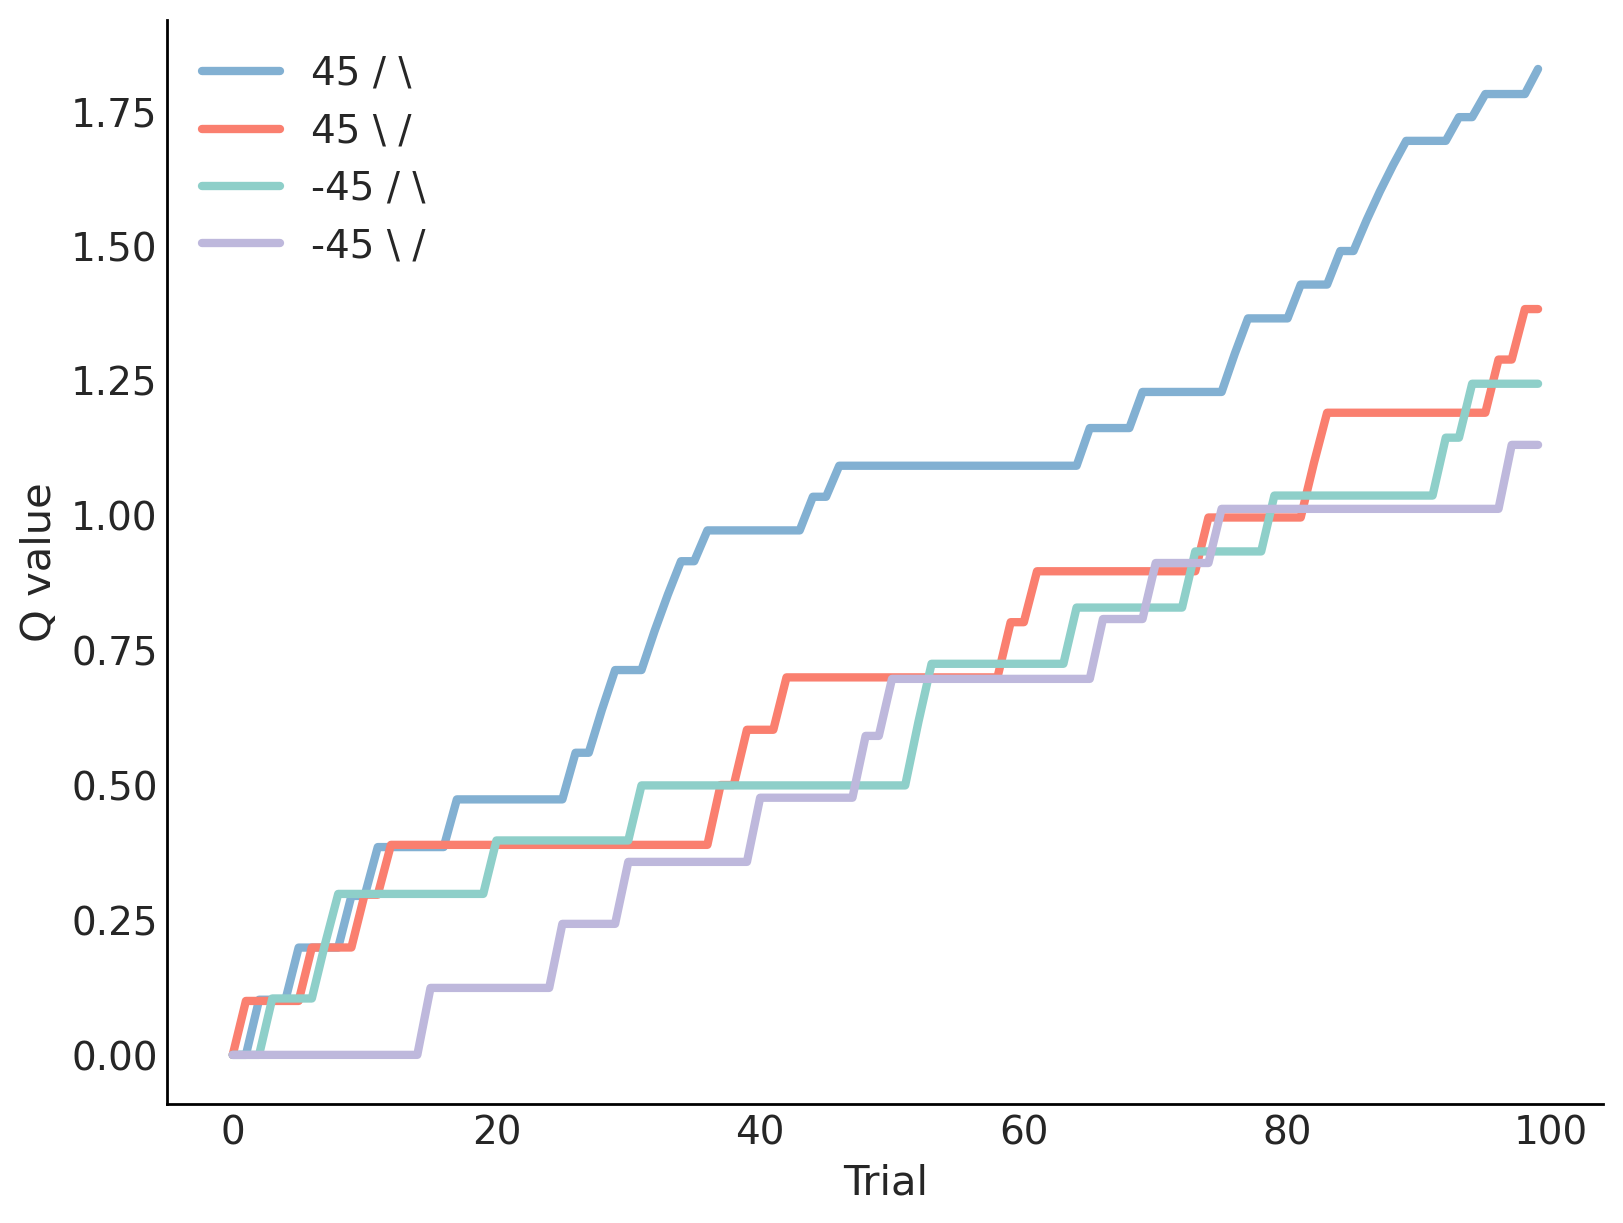

In [80]:
# Params Setting
learning_rate = 0.1
discount_factor = 0.9
num_trials = 100
epsilon = 0.1  # exploration rate

# Q Table Initialization
# 4 state, ori (0:45, 1:n45) x key (0: /  \,  1:\  /)
Q = np.zeros((4, 2))  # 4 states x 2 actions (Choose L or R)

# Simulation of Q Learning
all_Q_at_trial = []
for trial in range(num_trials):
    all_Q_at_trial.append(Q.copy())
    Q, current_state, correct_action, action, reward, td_error = RL_Q_run_trial(Q, epsilon, learning_rate, discount_factor, None)
    print("Trial {}: State: {}, Correct Action: {}, Action: {}, Reward: {}, TD Error: {}".format(
        trial + 1, current_state, correct_action, action, reward, td_error))

# # Print the learned Q table
# print("Learned Q-table:")
# print(Q)

# Visualize the learned Q table
plt.subplots(figsize=(8, 6))
plt.imshow(Q, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()
plt.xticks([0, 1], ["Left", "Right"])
plt.yticks([0, 1, 2, 3], ["45 / \\", "45 \\ /", "-45 / \\", "-45 \\ /"])
plt.xlabel("Action")
plt.ylabel("State")
plt.title("Learned Q-table")
plt.show()

# Visualize how the value of each state changes over trials
all_Q_at_trial = np.array(all_Q_at_trial)
plt.figure(figsize=(8, 6))
plt.plot(all_Q_at_trial[:, 0, 0], label="45 / \\", color=bl, linewidth=3)
plt.plot(all_Q_at_trial[:, 1, 1], label="45 \\ /", color=re, linewidth=3)
plt.plot(all_Q_at_trial[:, 2, 1], label="-45 / \\", color=gr, linewidth=3)
plt.plot(all_Q_at_trial[:, 3, 0], label="-45 \\ /", color=pu, linewidth=3)
plt.xlabel("Trial")
plt.ylabel("Q value")
plt.legend()
plt.show()

# 3 Combining the Perceptual Stage and Decision Stage

两个模型合起来构成了知觉决策的两阶段过程，第一阶段是知觉阶段，第二阶段是决策阶段。
- 在知觉阶段，被试会对每个试次中需要判断的朝向形成一定的先验概率，这个先验概率是由之前的试次中的判断结果得到的，这个先验概率会影响到被试对当前试次的判断结果。
- 在决策阶段，被试会根据知觉阶段得到的后验概率确定自己主观刺激的朝向，并和当前试次的反应模式一起组成state，再套用强化学习的模型对按键的价值进行更新。

In [82]:
## Run the simulation

##### Params Setting ########
num_trials = 50
# Bayesian Perception
init_prior = np.array([0.5,0.5])
base_accuracy = 0.75
updated_weight = 0.1
lapse_rate = 0.05
# Q Learning
learning_rate = 0.1
discount_factor = 0.9
epsilon = 0.1  # exploration rate
init_Q = np.zeros((4, 2))  # 4 states x 2 actions (Choose L or R)

##### Simulation ######

# Create a DataFrame to store the data
simulate_data = pd.DataFrame(columns=['Trial', 
                                      'Stimulus', 'Likelihood', 'Percept', 'Accuracy', 'Prior 0', 'Prior 1', 
                                      'State','Action', 'Reward', 'TD Error'])

for itest in range(num_trials):
    # Stimulus
    stim_ori = np.random.choice([0,1])
    
    # Bayesian Perception
    if itest == 0:
        prior = init_prior
    else:
        prior = updated_prior
    likelihood_correct = attention_fluctuation() 
    
    # Guessing if lapsed
    if np.random.rand() < lapse_rate:
        likelihood_correct = 0.5 
    _, percept_ori, accuracy, updated_prior = bayesian_percept_per_trial(prior, likelihood_correct, stim_ori, updated_weight)
    
    # Determine the current state
    pattern_choice = np.random.choice([0, 1]) # 0: / \, 1: \ /  
    if stim_ori == 0:
        if pattern_choice == 0:
            current_state = 0
        else:
            current_state = 1
    else:
        if pattern_choice == 0:
            current_state = 2
        else:
            current_state = 3
            
    ## In fact, the state is determined by the percept_ori and pattern_choice (since this is what the subject believes)
    if percept_ori == 0:
        if pattern_choice == 0:
            subj_current_state = 0
        else:
            subj_current_state = 1
    else:
        if pattern_choice == 0:
            subj_current_state = 2
        else:
            subj_current_state = 3
    
    # Q Learning
    if itest == 0:
        Q = init_Q
    Q, _, correct_action, action, reward, td_error = RL_Q_run_trial(Q, epsilon, learning_rate, discount_factor, subj_current_state)
    
    # Store the data
    temp_df = pd.DataFrame([[itest + 1, 
                            stim_ori, likelihood_correct, percept_ori, accuracy, prior[0], prior[1],
                            current_state, action, reward, td_error]],
                            columns=['Trial', 
                                      'Stimulus', 'Likelihood', 'Percept', 'Accuracy', 'Prior 0', 'Prior 1', 
                                      'State','Action', 'Reward', 'TD Error'])
    simulate_data = simulate_data.append(temp_df, ignore_index=True)
    

# 4 Test the SD Effect

In [83]:
# run 30 subjects, each with 20 blocks, each block has 50 trials

##### Params Setting ########
maxsubj = 30
maxblock = 20
num_trials = 50
# Bayesian Perception
init_prior = np.array([0.5,0.5])
base_accuracy = 0.75
updated_weight = 0.2
lapse_rate = 0.05
# Q Learning
learning_rate = 0.1
discount_factor = 0.7
epsilon = 0.3  # exploration rate
init_Q = np.zeros((4, 2))  # 4 states x 2 actions (Choose L or R)

##### Simulation ######

# Create a DataFrame to store the data
simulate_data = pd.DataFrame(columns=['Subject', 'Block', 'Trial',
                                      'Stimulus', 'Likelihood', 'Percept', 'Accuracy', 'Prior 0', 'Prior 1', 
                                      'State','Action', 'Reward', 'TD Error'])

for iS in range(1, maxsubj + 1):
    for iB in range(1, maxblock + 1):
        for itest in range(num_trials):
            # Stimulus
            stim_ori = np.random.choice([0,1])

            # Bayesian Perception
            if itest == 0:
                prior = init_prior
            else:
                prior = updated_prior
            likelihood_correct = attention_fluctuation() 

            # Guessing if lapsed
            if np.random.rand() < lapse_rate:
                likelihood_correct = 0.5 
            _, percept_ori, accuracy, updated_prior = bayesian_percept_per_trial(prior, likelihood_correct, stim_ori, updated_weight)
            
            # Determine the current state
            pattern_choice = np.random.choice([0, 1]) # 0: / \, 1: \ /  
            if stim_ori == 0:
                if pattern_choice == 0:
                    current_state = 0
                else:
                    current_state = 1
            else:
                if pattern_choice == 0:
                    current_state = 2
                else:
                    current_state = 3
                    
            ## In fact, the state is determined by the percept_ori and pattern_choice (since this is what the subject believes)
            if percept_ori == 0:
                if pattern_choice == 0:
                    subj_current_state = 0
                else:
                    subj_current_state = 1
            else:
                if pattern_choice == 0:
                    subj_current_state = 2
                else:
                    subj_current_state = 3
                    
            # Q Learning
            if itest == 0:
                Q = init_Q
            Q, _, correct_action, action, reward, td_error = RL_Q_run_trial(Q, epsilon, learning_rate, discount_factor, subj_current_state)

            # Store the data
            temp_df = pd.DataFrame([[iS, iB, itest + 1, 
                                     stim_ori, likelihood_correct, percept_ori, accuracy, prior[0], prior[1],
                                    current_state, action, reward, td_error]],
                                    columns=['Subject', 'Block', 'Trial',
                                      'Stimulus', 'Likelihood', 'Percept', 'Accuracy', 'Prior 0', 'Prior 1', 
                                      'State','Action', 'Reward', 'TD Error'])
            simulate_data = simulate_data.append(temp_df, ignore_index=True)


In [84]:
simulate_data.head()

,Subject,Block,Trial,Stimulus,Likelihood,Percept,Accuracy,Prior 0,Prior 1,State,Action,Reward,TD Error
0,1,1,1,1,0.748925,1,True,0.500000,0.500000,3,0,1,1.000000
1,1,1,2,1,0.798543,1,True,0.472342,0.527658,2,1,1,1.017500
2,1,1,3,0,0.500000,0,True,0.439393,0.560607,0,0,1,1.035306
3,1,1,4,1,0.843017,1,True,0.439393,0.560607,2,1,1,0.951674
4,1,1,5,1,0.802869,1,True,0.402183,0.597817,3,1,-1,-0.929922


In [85]:
trial_template = pd.DataFrame(columns=['StimSeq', 'RespOri', 'RespLorR', 'Accuracy', 'ProbeOriLeft', 'ProbeOriRight', 'Qualified'])
all_data = {}

maxsubj = 30
for iS in range(1, maxsubj + 1):
    subject_data = []
    raw_subj = simulate_data[simulate_data['Subject'] == iS]
    for iB in range(1, maxblock + 1):
        block_data = raw_subj[raw_subj['Block'] == iB]
        temp_data = trial_template.copy()
        temp_data['StimSeq'] = block_data['Stimulus'].values.copy()
        temp_data['StimSeq'].replace({0: 45, 1: -45}, inplace=True)
        temp_data['RespOri'] = block_data['Percept'].values.copy()
        temp_data['RespOri'].replace({0: 45, 1: -45}, inplace=True)
        temp_data['RespLorR'] = block_data['Action'].values.copy()
        temp_data['RespLorR'].replace({0: -1}, inplace=True)
        temp_data['Accuracy'] = block_data['Accuracy'].values.copy()
        temp_data['Accuracy'].replace({False: 0, True: 1}, inplace=True)
        temp_data['ProbeOriLeft'] = block_data['State'].values.copy()
        temp_data['ProbeOriLeft'].replace({0: 45, 2: 45, 1: -45, 3: -45}, inplace=True)
        temp_data['ProbeOriRight'] = block_data['State'].values.copy()
        temp_data['ProbeOriRight'].replace({0: -45, 2: -45, 1: 45, 3: 45}, inplace=True)    
        temp_data['Qualified'] = True
        subject_data.append(temp_data)
    all_data[iS] = subject_data


## 4.1 Draw All the Accuracies

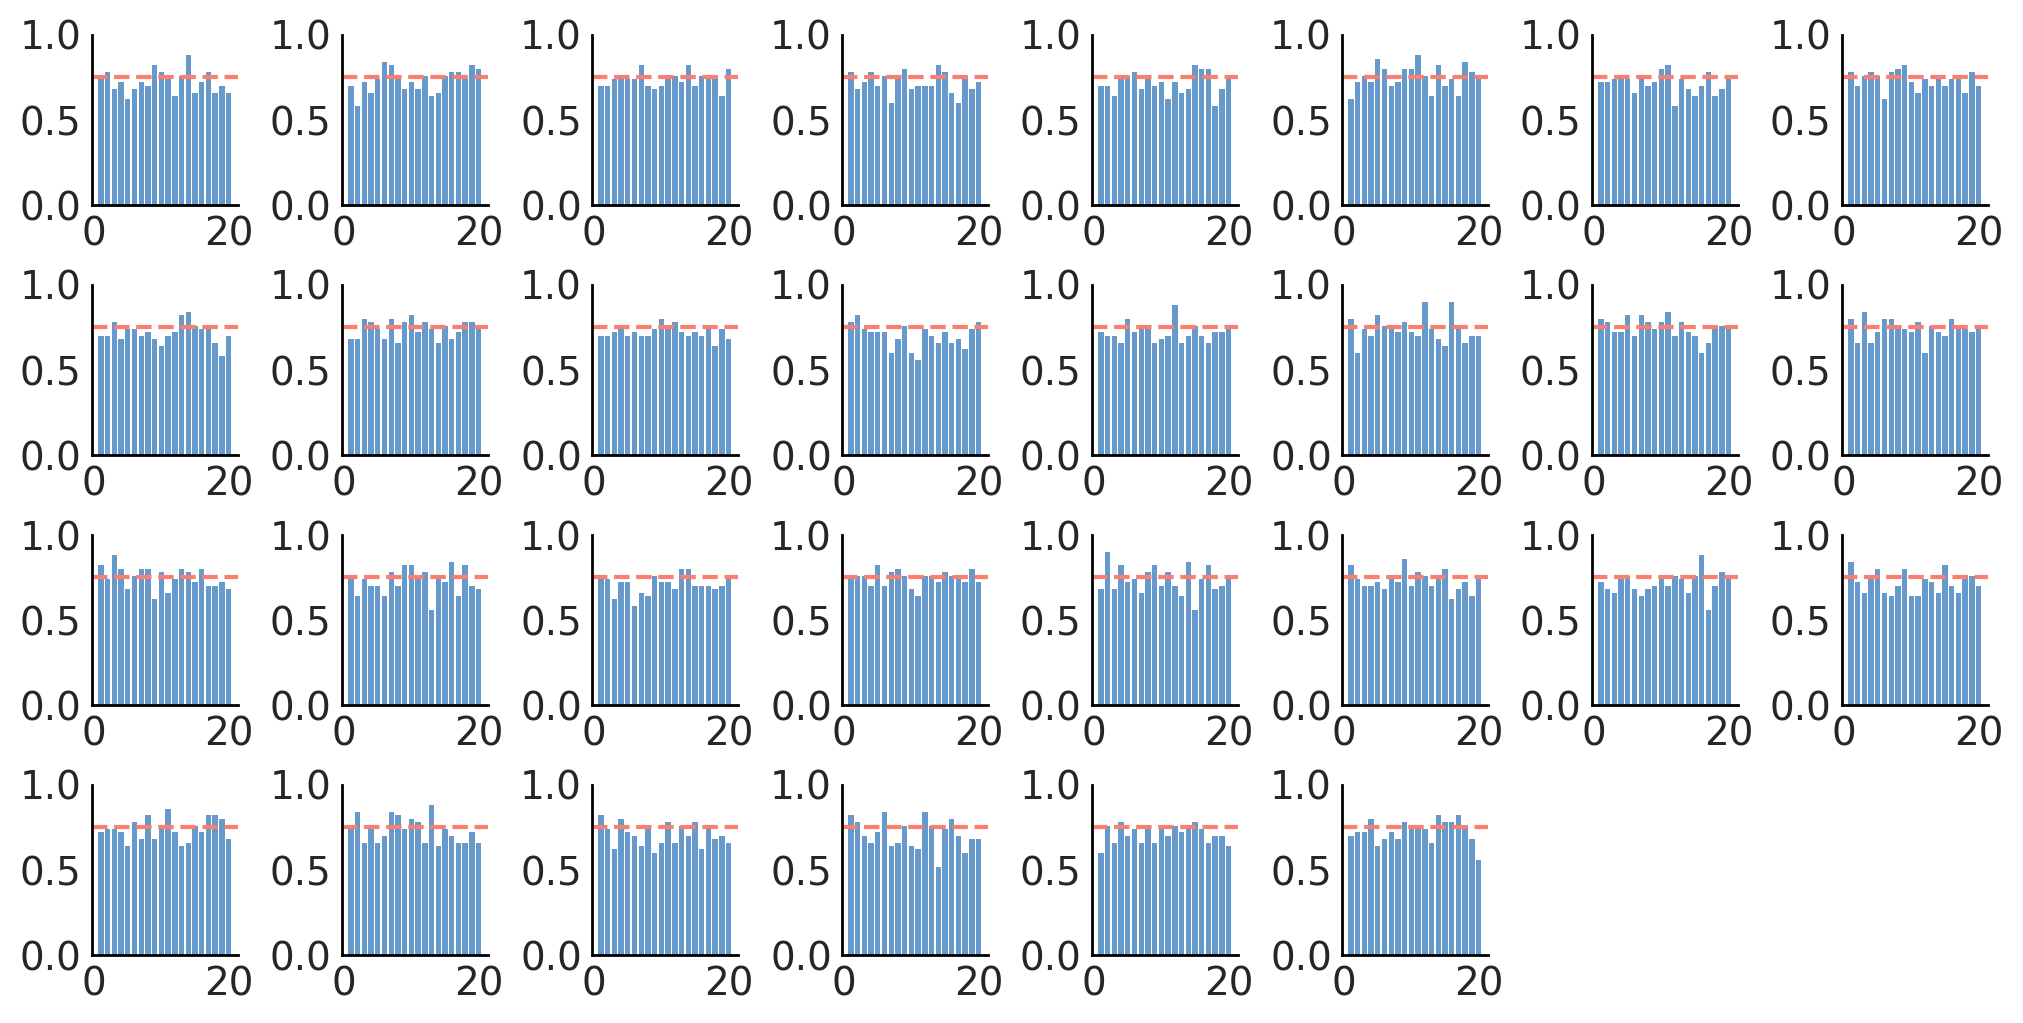

In [86]:
maxsubj = 30; maxblock = 20; maxtrial = 50

plt.figure(figsize=(10, 5))

for iS in range(1, maxsubj + 1):
    subject_data = all_data[iS]  # all blocks for this subject
    temp_accuracy = {f"{i}_block": {} for i in range(1, maxblock + 1)}
    for iB in range(1, maxblock + 1):
        key = f"{iB}_block"
        block_data = subject_data[iB - 1]  # read current block
        temp_accuracy[key] = np.mean(block_data['Accuracy'])
    plt.subplot(4, 8, iS)
    plt.bar([int(i.split('_')[0]) for i in temp_accuracy.keys()], temp_accuracy.values(), color=grb)
    plt.ylim([0, 1])
    plt.axhline(y=0.75, color=re, linestyle='--')

## 4.2 Perceptual Serial Dependence (Combined)

In [87]:
def criterion(hit, FA):
    return -0.5*(stats.norm.ppf(hit) + stats.norm.ppf(FA))

def dprime(hit, FA):
    return (stats.norm.ppf(hit) - stats.norm.ppf(FA))/np.sqrt(2)

def hit_fa(df):
    hit = df[(df['StimSeq'] == 45)]['Accuracy']
    fa = 1 - df[(df['StimSeq'] == -45)]['Accuracy']
    return hit, fa

def hit_fa_motor(df):
    hit = df[(df['StimSeq'] == df['ProbeOriRight'])]['Accuracy']
    fa = 1 - df[(df['StimSeq'] == df['ProbeOriLeft'])]['Accuracy']
    return hit, fa

In [88]:
maxsubj = 30; maxblock = 20; maxtrial = 50; num_backs = 5  # n-backs

# Dictionary to store data for different back levels
SD_back_Percept_Y_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)} # 1-10 back, with correct feedback (correct response)
SD_back_Percept_N_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)} # 1-10 back, with incorrect feedback (incorrect response)
criterion_Percept_Y_45_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)} # 1-10 back, with correct feedback (correct response)
criterion_Percept_N_45_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)} # 1-10 back, with incorrect feedback (incorrect response)
criterion_Percept_Y_n45_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)} # 1-10 back, with correct feedback (correct response)
criterion_Percept_N_n45_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)} # 1-10 back, with incorrect feedback (incorrect response)

def process_data_percept_FB_cb(data, back, feedback):
    """Process data and return hits and false alarms"""
    hit, fa = hit_fa(data[(data['RespOri'].shift(back) == 45) & (data['Accuracy'].shift(back) == feedback) & (data['Qualified'] == True)])
    hit_n, fa_n = hit_fa(data[(data['RespOri'].shift(back) == -45) & (data['Accuracy'].shift(back) == feedback) & (data['Qualified'] == True)])
    return (hit, fa, hit_n, fa_n)

FB_types = [1, 0]  # 1: correct feedback; 0: incorrect feedback

for iS in range(1, maxsubj + 1):
    subject_data = all_data[iS]  # Get all block data for the current subject
    
    # Create a temporary dictionary to store data for each back level
    temp_data_Y = {f"{i}_back": {"Hit": [], "FA": [], "Hit_n": [], "FA_n": []} for i in range(1, num_backs + 1)}
    temp_data_N = {f"{i}_back": {"Hit": [], "FA": [], "Hit_n": [], "FA_n": []} for i in range(1, num_backs + 1)}
    temp_data = {1: temp_data_Y, 0: temp_data_N}
    
    for iFB in FB_types:
        feedback = iFB
        for iB in range(1, maxblock + 1):
            block_data = subject_data[iB - 1] # Get data for the current block
            for back in range(1, num_backs + 1):
                hits_fa = process_data_percept_FB_cb(block_data, back, feedback)
                temp_data[feedback][f"{back}_back"]["Hit"].append(hits_fa[0])
                temp_data[feedback][f"{back}_back"]["FA"].append(hits_fa[1])
                temp_data[feedback][f"{back}_back"]["Hit_n"].append(hits_fa[2])
                temp_data[feedback][f"{back}_back"]["FA_n"].append(hits_fa[3])

    # Calculate the criterion score for each back level and add it to SD_back_Percept_Y and SD_back_Percept_N
    for iFB in FB_types:
        feedback = iFB
        for back in range(1, num_backs + 1):
            key = f"{back}_back"
            hits = np.concatenate(temp_data[feedback][key]["Hit"])
            fas = np.concatenate(temp_data[feedback][key]["FA"])
            hits_n = np.concatenate(temp_data[feedback][key]["Hit_n"])
            fas_n = np.concatenate(temp_data[feedback][key]["FA_n"])
            cri_45 = criterion(np.mean(hits), np.mean(fas))
            cri_n45 = criterion(np.mean(hits_n), np.mean(fas_n))
            SD_back_percept = cri_n45 - cri_45
#             temp_output = {'h':format(np.mean(hits),}
#             print(iFB, '_', key, ' :: ', temp_output)
            if feedback == 1:
                SD_back_Percept_Y_cb[key].append(SD_back_percept)
                criterion_Percept_Y_45_cb[key].append(cri_45)
                criterion_Percept_Y_n45_cb[key].append(cri_n45)
            else:
                SD_back_Percept_N_cb[key].append(SD_back_percept)
                criterion_Percept_N_45_cb[key].append(cri_45)
                criterion_Percept_N_n45_cb[key].append(cri_n45)
    print('done ', end="@")

SD_nbacks_Percept_Y_cb = pd.DataFrame(SD_back_Percept_Y_cb)
SD_nbacks_Percept_N_cb = pd.DataFrame(SD_back_Percept_N_cb)
criterion_nbacks_Percept_Y_45_cb = pd.DataFrame(criterion_Percept_Y_45_cb)
criterion_nbacks_Percept_Y_n45_cb = pd.DataFrame(criterion_Percept_Y_n45_cb)
criterion_nbacks_Percept_N_45_cb = pd.DataFrame(criterion_Percept_N_45_cb)
criterion_nbacks_Percept_N_n45_cb = pd.DataFrame(criterion_Percept_N_n45_cb)

done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @

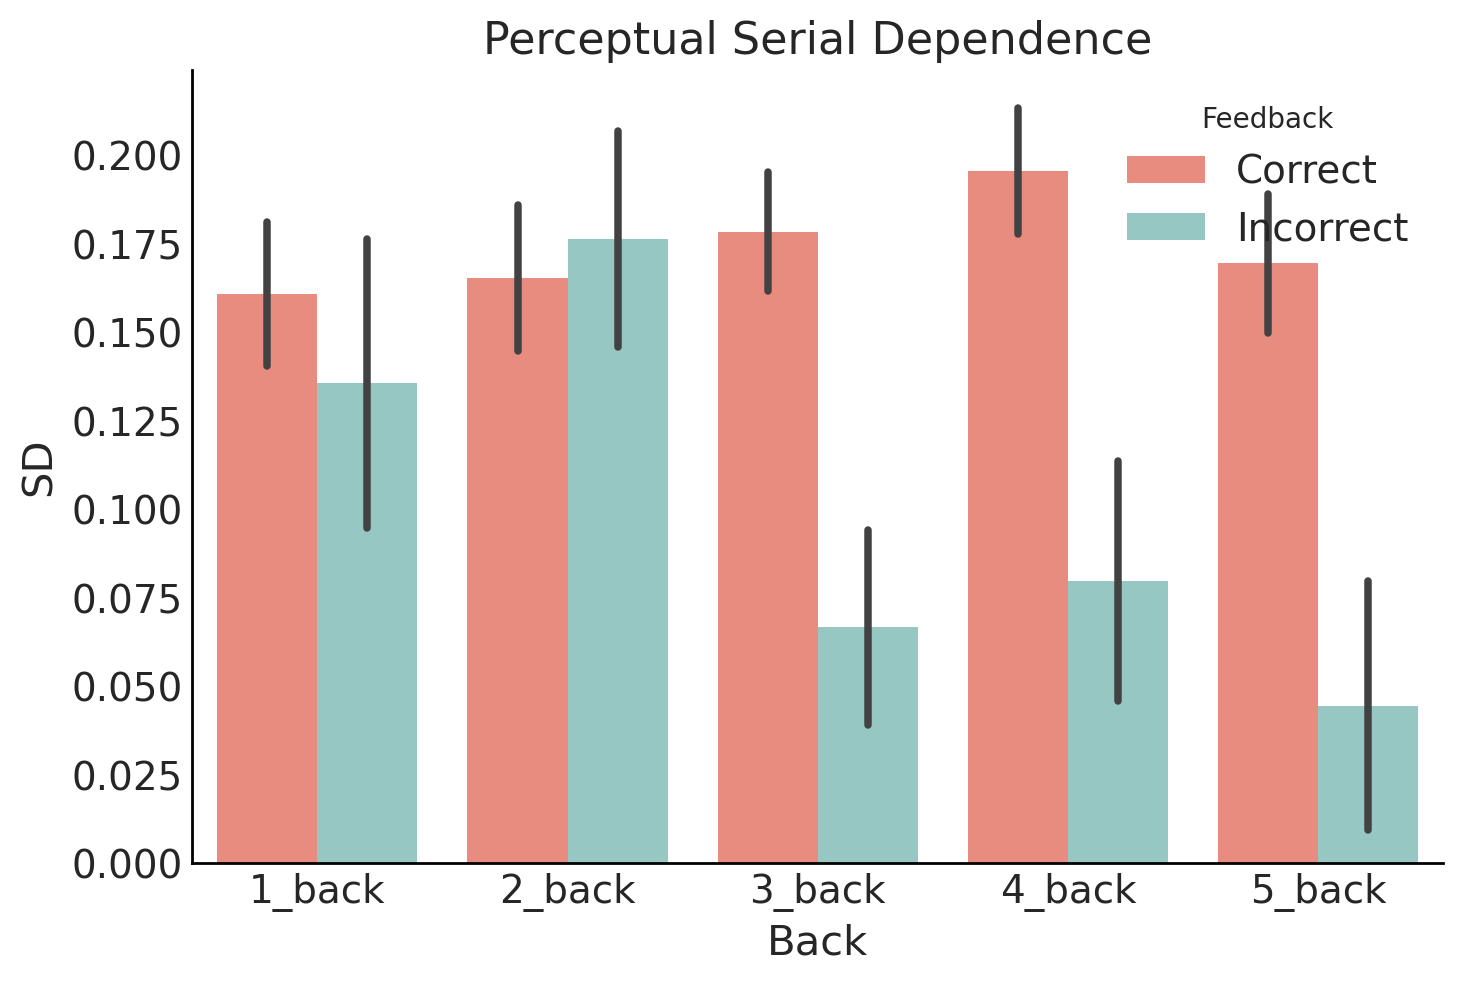

In [89]:
SD_nbacks_Percept_N_cb['Feedback'] = 'Incorrect'
SD_nbacks_Percept_Y_cb['Feedback'] = 'Correct'
SD_nbacks_Percept_N_cb['Subject'] = np.arange(1, maxsubj + 1)
SD_nbacks_Percept_Y_cb['Subject'] = np.arange(1, maxsubj + 1)
SD_Percept_FB = pd.concat([SD_nbacks_Percept_Y_cb, SD_nbacks_Percept_N_cb], ignore_index=True)
SD_Percept_FB = SD_Percept_FB.melt(id_vars=['Subject', 'Feedback'], var_name='Back', value_name='SD')

sns.barplot(x='Back', y='SD', hue='Feedback', data=SD_Percept_FB, palette=[re, gr], errorbar='se')
plt.title('Perceptual Serial Dependence')
plt.show()

## 4.2 Motor Serial Dependence (Combined)

In [90]:
maxsubj = 30 ;maxblock = 20 ;maxtrial = 50 ;num_backs = 5  # 1-back to 10-back

# all data from nbacks
SD_nback_Motor_Y_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)}
SD_nback_Motor_N_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)}
criterion_Motor_Y_L_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)}
criterion_Motor_Y_R_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)}
criterion_Motor_N_L_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)}
criterion_Motor_N_R_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)}

def process_data_motor_FB_cb(data, back, feedback):
    """Process data and return hits and false alarms"""
    hit_l, fa_l = hit_fa_motor(data[(data['RespLorR'].shift(back) == -1) & (data['Accuracy'].shift(back) == feedback) & (data['Qualified'] == True)])
    hit_r, fa_r = hit_fa_motor(data[(data['RespLorR'].shift(back) == 1) & (data['Accuracy'].shift(back) == feedback) & (data['Qualified'] == True)])
    return (hit_l, fa_l, hit_r, fa_r)

FB_types = [1, 0]  # 1: correct feedback; 0: incorrect feedback

for iS in range(1, maxsubj + 1):
    subject_data = all_data[iS]  # Get all block data for the current subject
    
    # Create a temporary dictionary to store data for each back level
    temp_data_Y = {f"{i}_back": {"Hit_L": [], "FA_L": [], "Hit_R": [], "FA_R": []} for i in range(1, num_backs + 1)}
    temp_data_N = {f"{i}_back": {"Hit_L": [], "FA_L": [], "Hit_R": [], "FA_R": []} for i in range(1, num_backs + 1)}
    temp_data = {1: temp_data_Y, 0: temp_data_N}
    
    for iFB in FB_types:
        feedback = iFB
        for iB in range(1, maxblock + 1):
            block_data = subject_data[iB - 1] # Get data for the current block
            for back in range(1, num_backs + 1):
                hits_fa = process_data_motor_FB_cb(block_data, back, feedback)
                temp_data[feedback][f"{back}_back"]["Hit_L"].append(hits_fa[0])
                temp_data[feedback][f"{back}_back"]["FA_L"].append(hits_fa[1])
                temp_data[feedback][f"{back}_back"]["Hit_R"].append(hits_fa[2])
                temp_data[feedback][f"{back}_back"]["FA_R"].append(hits_fa[3])

    # Calculate the criterion score for each back level and add it to SD_back_Percept_Y and SD_back_Percept_N
    for iFB in FB_types:
        feedback = iFB
        for back in range(1, num_backs + 1):
            key = f"{back}_back"
            hits_l = np.concatenate(temp_data[feedback][key]["Hit_L"])
            fas_l = np.concatenate(temp_data[feedback][key]["FA_L"])
            hits_r = np.concatenate(temp_data[feedback][key]["Hit_R"])
            fas_r = np.concatenate(temp_data[feedback][key]["FA_R"])
            cri_l = criterion(np.mean(hits_l), np.mean(fas_l))
            cri_r = criterion(np.mean(hits_r), np.mean(fas_r))
            SD_back_motor = cri_l - cri_r
            if feedback == 1:
                SD_nback_Motor_Y_cb[key].append(SD_back_motor)
                criterion_Motor_Y_L_cb[key].append(cri_l)
                criterion_Motor_Y_R_cb[key].append(cri_r)
            else:
                SD_nback_Motor_N_cb[key].append(SD_back_motor)
                criterion_Motor_N_L_cb[key].append(cri_l)
                criterion_Motor_N_R_cb[key].append(cri_r)
    print('done ', end="@")

SD_nbacks_Motor_Y_cb = pd.DataFrame(SD_nback_Motor_Y_cb)
SD_nbacks_Motor_N_cb = pd.DataFrame(SD_nback_Motor_N_cb)
Criterion_Motor_Y_L_cb = pd.DataFrame(criterion_Motor_Y_L_cb)
Criterion_Motor_Y_R_cb = pd.DataFrame(criterion_Motor_Y_R_cb)
Criterion_Motor_N_L_cb = pd.DataFrame(criterion_Motor_N_L_cb)
Criterion_Motor_N_R_cb = pd.DataFrame(criterion_Motor_N_R_cb)


done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @

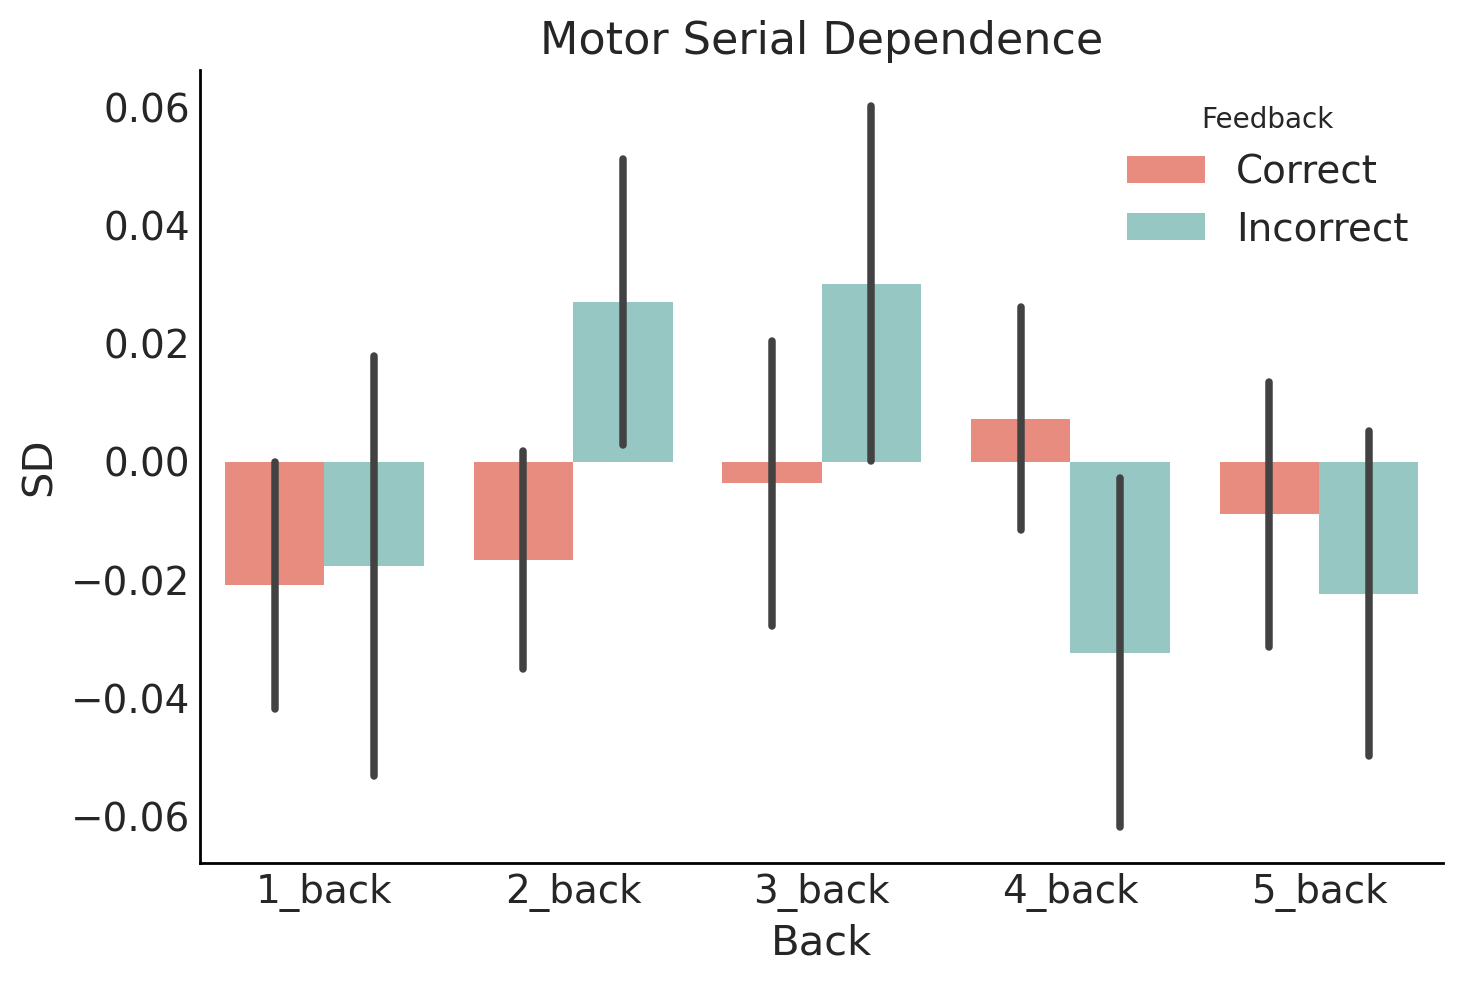

In [91]:
SD_nbacks_Motor_Y_cb['Feedback'] = 'Correct'
SD_nbacks_Motor_N_cb['Feedback'] = 'Incorrect'
SD_nbacks_Motor_Y_cb['Subject'] = np.arange(1, maxsubj + 1)
SD_nbacks_Motor_N_cb['Subject'] = np.arange(1, maxsubj + 1)
SD_Motor_FB = pd.concat([SD_nbacks_Motor_Y_cb, SD_nbacks_Motor_N_cb], ignore_index=True)
SD_Motor_FB = SD_Motor_FB.melt(id_vars=['Subject', 'Feedback'], var_name='Back', value_name='SD')

sns.barplot(x='Back', y='SD', hue='Feedback', data=SD_Motor_FB, palette=[re, gr], errorbar='se')
plt.title('Motor Serial Dependence')
plt.show()

# X Summary


目前的模型：
- 可以实现**吸引性**的知觉SD（Bayesian Prior），与按键上的**排斥性**SD（Exploitation Algorithm）。
- 但是知觉上的首先不显著，其次反馈的效应并不明显，并且这个模型整体并没有考虑试次难度的影响，

# Save Progress

In [93]:
import dill
import datetime
model_name = 'model_1'
date = datetime.datetime.today().strftime('%Y%m%d')
filename = f'{path}{model_name}_{date}.db'
print(filename)
dill.dump_session(filename)


./Data/model_1_20231220.db


In [2]:
import dill
dill.load_session('SD_1219.db')